## Model 4

This first model consists of a simple 3D autoencoder with 2 conv3D and 2 conv3DTranspose. Compression ratio is (2^3)^4 = 4096 divided across 20 filters, that would make: 4096/20 = 204.8 = CP. 

In [1]:
import time
import numpy as np
import xarray as xr
import tensorflow as tf
from collections import OrderedDict
from keras.callbacks import LearningRateScheduler
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data
from lossycomp.utils import check_gpu, Autoencoder, decay_schedule, r2_coef
from lossycomp.plots import mult_plot, single_plot, plot_history

In [6]:
 model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 40], [4, 4, 4, 4], [2, 2, 2, 2])

In [7]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 8, 24, 24, 10)     650       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 12, 12, 20)     12820     
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 2, 6, 6, 20)       25620     
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1, 3, 3, 40)       51240     
_________________________________________________________________
conv3d_transpose_8 (Conv3DTr (None, 2, 6, 6, 20)       51220     
_________________________________________________________________
conv3d_transpose_9 (Conv3DTr (None, 4, 12, 12, 20)    

In [8]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

In [9]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_train = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 
dg_test = DataGenerator(test, 20000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM
Loading data into RAM


In [10]:
lr_scheduler = LearningRateScheduler(decay_schedule)

In [ ]:
history = model.fit(dg_train, validation_data = dg_test, epochs=100, callbacks=[lr_scheduler])#,workers = 4)#, use_multiprocessing = True)

Epoch 1/100
1000/1000 [==============================] - 55s 55ms/step - loss: 0.4953 - r2_coef: 0.6958 - MAE: 0.4363 - val_loss: 0.1070 - val_r2_coef: 0.9336 - val_MAE: 0.2344
Epoch 2/100
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0633 - r2_coef: 0.9612 - MAE: 0.1766 - val_loss: 0.0756 - val_r2_coef: 0.9536 - val_MAE: 0.1978
Epoch 3/100
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0433 - r2_coef: 0.9733 - MAE: 0.1469 - val_loss: 0.0651 - val_r2_coef: 0.9594 - val_MAE: 0.1831
Epoch 4/100
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0354 - r2_coef: 0.9781 - MAE: 0.1326 - val_loss: 0.0577 - val_r2_coef: 0.9640 - val_MAE: 0.1717
Epoch 5/100
 214/1000 [=====>........................] - ETA: 32s - loss: 0.0318 - r2_coef: 0.9802 - MAE: 0.1255

In [6]:
model.save_weights('model4/weights')
#model.load_weights('model3/weights')

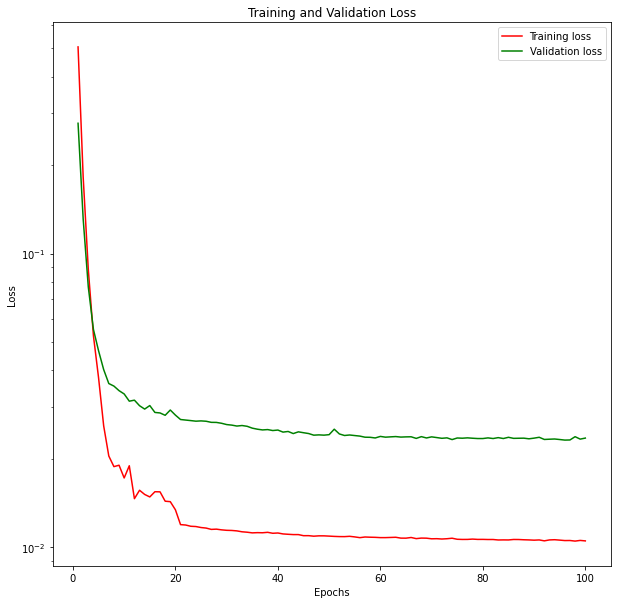

In [9]:
plot_history(history, 'loss', 'Training and Validation Loss', 'Epochs', 'Loss')

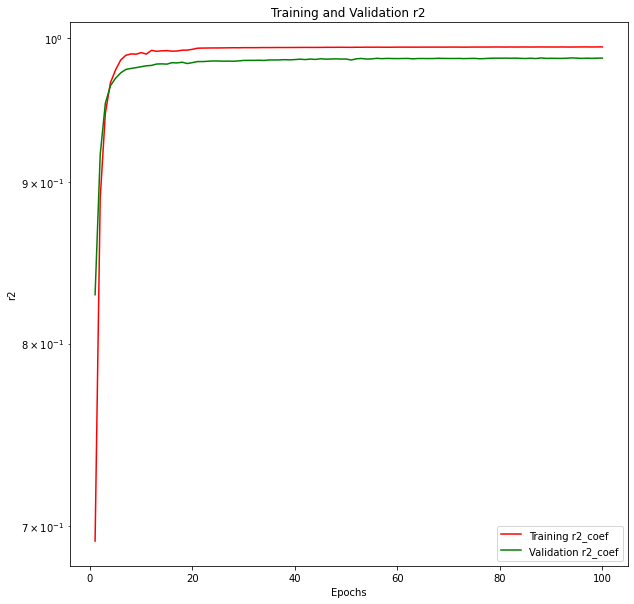

In [10]:
plot_history(history, 'r2_coef', 'Training and Validation r2', 'Epochs', 'r2')

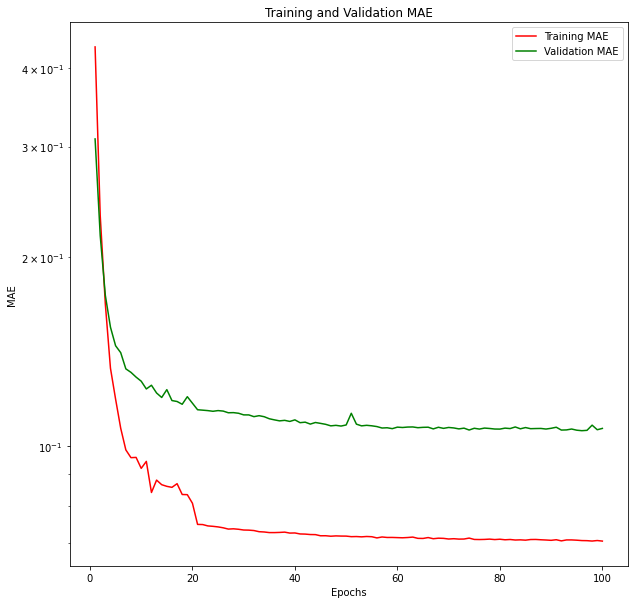

In [11]:
plot_history(history, 'MAE', 'Training and Validation MAE', 'Epochs', 'MAE')

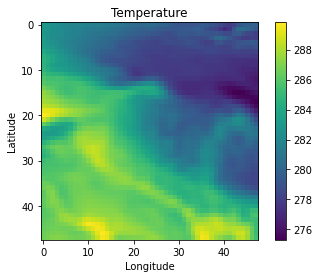

In [12]:
a = dg_test.__getitem__(2)[0] 
a_n = norm_data(a, mean, std)
single_plot(a_n, 10, "Temperature")

In [13]:
import numpy as np
result = model(np.expand_dims(a[0], axis=0)).numpy()

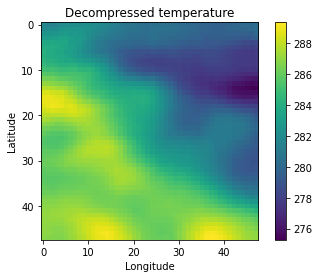

In [14]:
result = norm_data(result, mean, std)
single_plot(result, 10, "Decompressed temperature" )

In [7]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1980-01-14T16:00:00','1980-01-15T07:00:00'),level = slice(978,1000), longitude=slice(6,17.75), latitude=slice(55.5,43.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 16, 48, 48, 1)

## Results

Original:

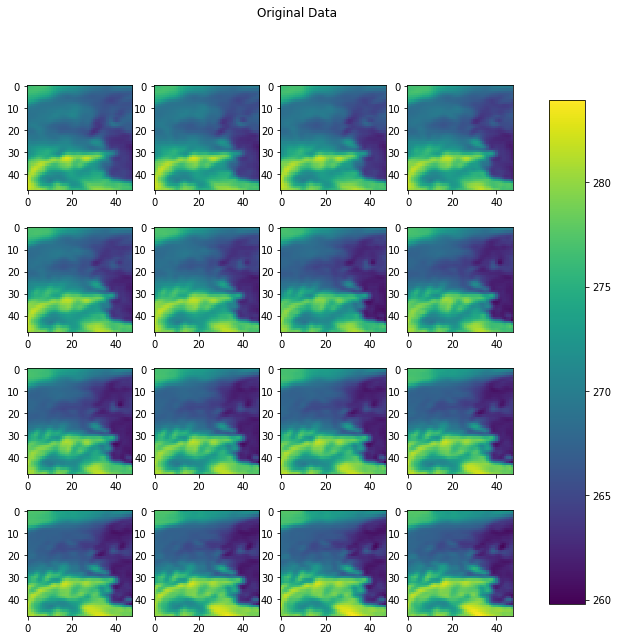

In [8]:
test_n = norm_data(test_data, mean, std)
mult_plot(test_n, 4, 4, "Original Data", test_n.min(), test_n.max())

Decompressed:

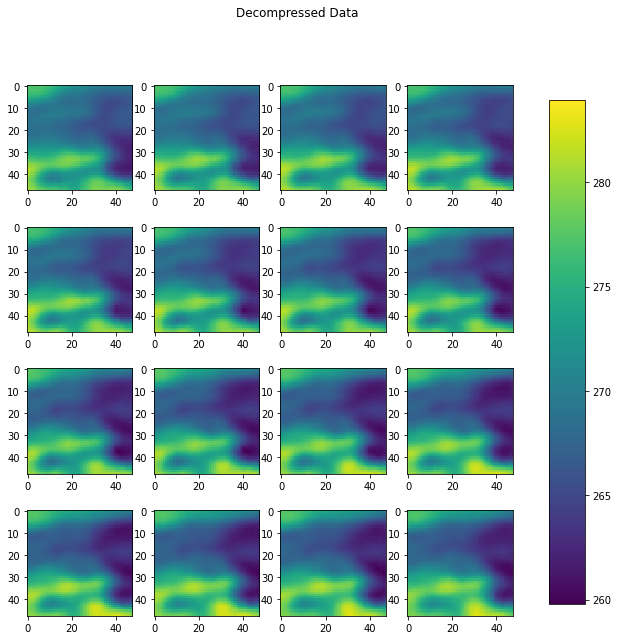

In [9]:
result2 = model(test_data).numpy()
result2 = norm_data(result2, mean, std)

mult_plot(result2, 4, 4, "Decompressed Data", test_n.min(), test_n.max())

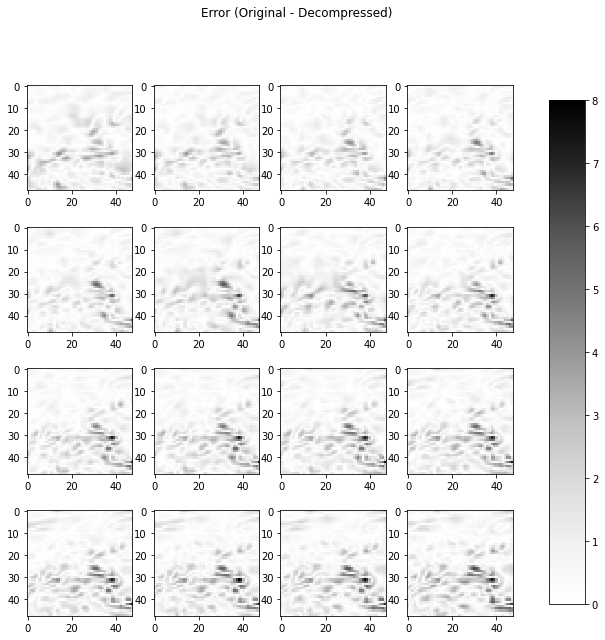

In [10]:
result3 = np.absolute(test_n-result2)
mult_plot(result3, 4, 4, "Error (Original - Decompressed)", result3.min(), result3.max(), 'Greys')

## Get encoder output

In [13]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('conv3d_3').output)

In [15]:
intermediate_output = intermediate_layer_model(test_data).numpy()
intermediate_output.shape

(1, 1, 3, 3, 20)

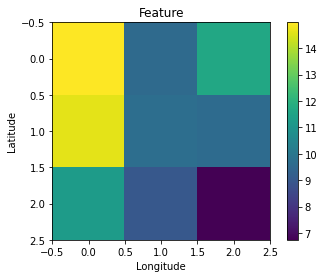

In [17]:
single_plot(intermediate_output, 0, "Feature")

In [19]:
print("# Bytes data:", test_data.nbytes)
print("# Bytes compressed data:", intermediate_output.nbytes)

# Bytes data: 147456
# Bytes compressed data: 720


In [23]:
import fpzip
compressed_bytes = fpzip.compress(test_data[0], precision=16, order='C')
print("# Bytes compressed data:", len(compressed_bytes)) 

# Bytes compressed data: 27159


## Validation

### Europe

In [16]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [17]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 47s 47ms/step - loss: 0.0104 - r2_coef: 0.9933 - MAE: 0.0700


In [18]:
results

[0.010386383160948753, 0.9933449625968933, 0.07004484534263611]

### World

In [21]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "globe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [22]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 67s 67ms/step - loss: 0.0131 - r2_coef: 0.9980 - MAE: 0.0668


In [23]:
results

[0.013058239594101906, 0.9980311393737793, 0.06677353382110596]

### Sahara

In [36]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1979-01-14T16:00:00','1979-01-15T07:00:00'),level = slice(978,1000), longitude=slice(-5,6.75), latitude=slice(26.75,15))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 16, 48, 48, 1)

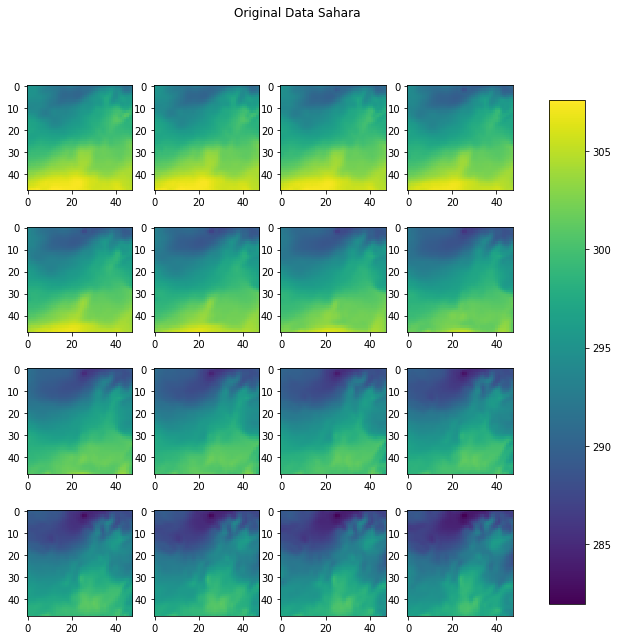

In [37]:
test_n = norm_data(test_data, mean, std)
mult_plot(test_n, 4, 4, "Original Data Sahara", test_n.min(), test_n.max())

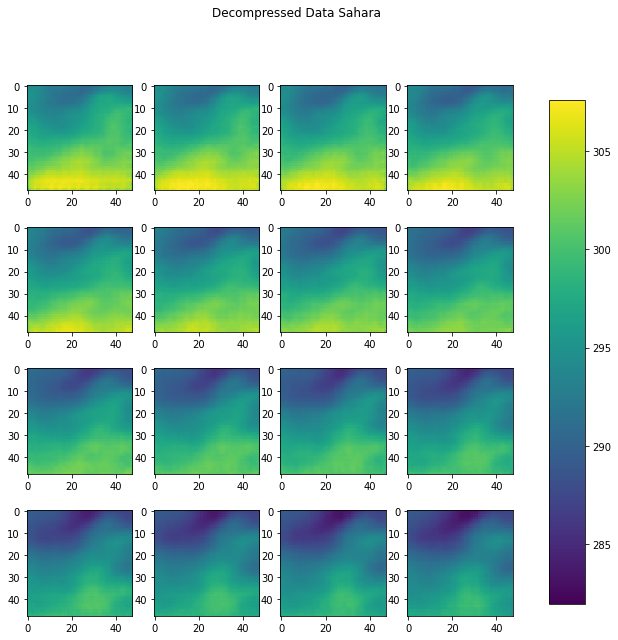

In [38]:
result2 = model(test_data).numpy()
result2 = norm_data(result2, mean, std)

mult_plot(result2, 4, 4, "Decompressed Data Sahara", test_n.min(), test_n.max())

In [12]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "sahara_desert"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [13]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 45s 45ms/step - loss: 0.0560 - r2_coef: 0.9661 - MAE: 0.1565


In [14]:
results

[0.05598219856619835, 0.96607506275177, 0.15647469460964203]

### Polar

In [49]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1979-01-14T16:00:00','1979-01-15T07:00:00'),level = slice(978,1000), longitude=slice(-5,6.75), latitude=slice(90,78.2))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 16, 48, 48, 1)

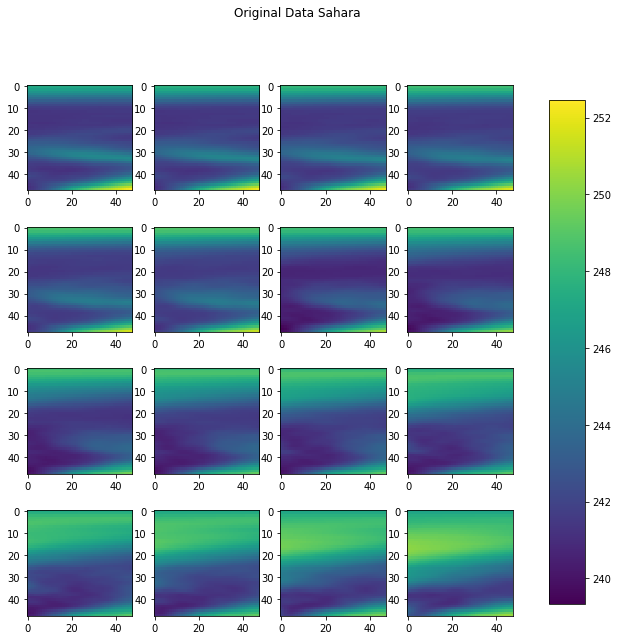

In [50]:
test_n = norm_data(test_data, mean, std)
mult_plot(test_n, 4, 4, "Original Data Sahara", test_n.min(), test_n.max())

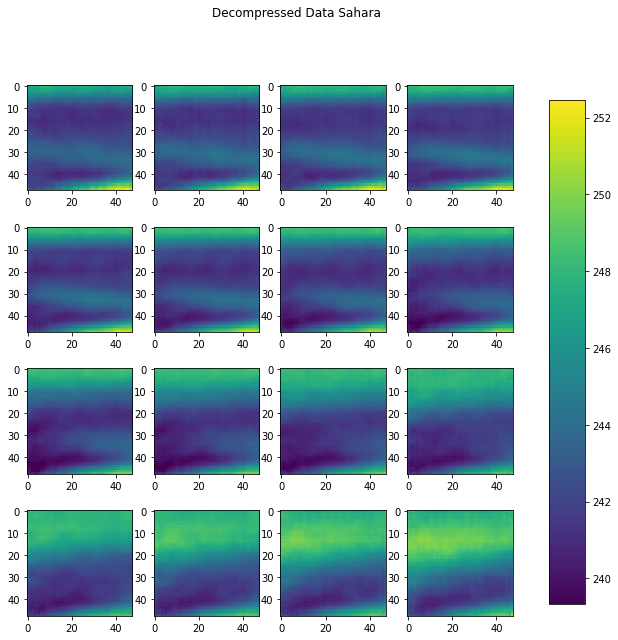

In [51]:
result2 = model(test_data).numpy()
result2 = norm_data(result2, mean, std)

mult_plot(result2, 4, 4, "Decompressed Data Sahara", test_n.min(), test_n.max())

### Polar zone

In [9]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "polar_zone"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [10]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 48s 48ms/step - loss: 0.0095 - r2_coef: 0.9975 - MAE: 0.0613


In [11]:
results

[0.0094641437754035, 0.9975417256355286, 0.061331238597631454]

### Greenland

In [15]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "greenland"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [16]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 45s 45ms/step - loss: 0.0120 - r2_coef: 0.9934 - MAE: 0.0747


In [17]:
results

[0.011959177441895008, 0.9933539032936096, 0.07471045106649399]

### Pacific Ocean

In [18]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "pacific_ocean"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [19]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 47s 47ms/step - loss: 0.0025 - r2_coef: 0.9987 - MAE: 0.0356


In [20]:
results

[0.0025288399774581194, 0.9987303018569946, 0.035597044974565506]

### Tibet

In [21]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "tibet"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [22]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 44s 44ms/step - loss: 0.0539 - r2_coef: 0.9470 - MAE: 0.1290


In [23]:
results

[0.0539131723344326, 0.9470359086990356, 0.12901067733764648]

### Subtropical zone

In [24]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "subtropical_zone"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [25]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 47s 47ms/step - loss: 0.0228 - r2_coef: 0.9837 - MAE: 0.0865


In [26]:
results

[0.022801533341407776, 0.9836617112159729, 0.08646497130393982]

### Tropical zone

In [27]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "tropical_zone"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [28]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 50s 50ms/step - loss: 0.0129 - r2_coef: 0.9433 - MAE: 0.0654


In [29]:
results

[0.012946909293532372, 0.9433071613311768, 0.06539389491081238]

### Temperate zone

In [31]:
file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "tropical_zone"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_validation = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std)

Loading data into RAM


In [32]:
results = model.evaluate(dg_validation)

1000/1000 [==============================] - 49s 49ms/step - loss: 0.0127 - r2_coef: 0.9433 - MAE: 0.0650


In [33]:
results

[0.012744247913360596, 0.9432854056358337, 0.06497360020875931]